## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [127]:
%matplotlib inline
from time import time, sleep
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
sns.set()
from IPython import display
from IPython.display import clear_output

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

In [64]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])

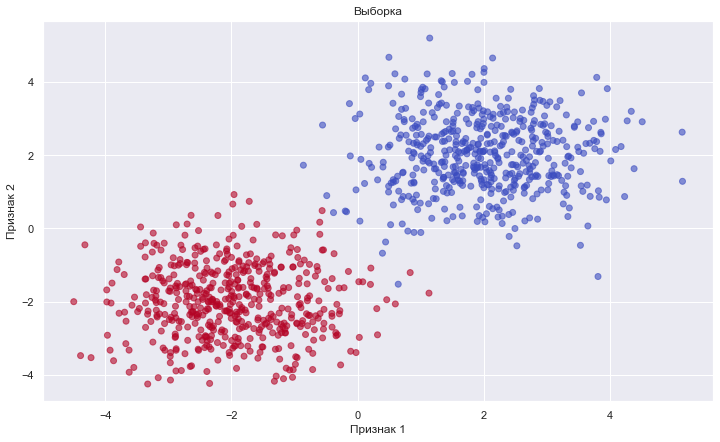

In [65]:
plt.figure(figsize=(12,7))
plt.title('Выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(X[:,0], X[:,1], c = Y[:,0], cmap='coolwarm_r', alpha=0.6)
plt.show()

Define a **logistic regression** for debugging. 

In [66]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [67]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [11]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

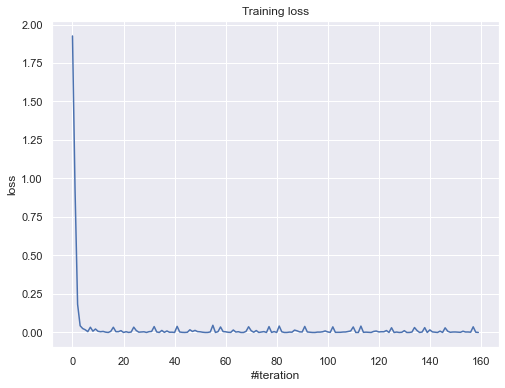

Current loss: 0.000215


In [69]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

n_features = X_train[0].size

One-hot encode the labels first.

In [5]:
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_val = ohe.transform(y_val.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

n_classes = y_train.shape[1]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

Функции для обучения модели

In [6]:
def train_epoch(model, 
                data, 
                batch_size, 
                criterion,
                optimizer=None, 
                optimizer_params=None):
    '''
    Одна эпоха обучения / валидации
    '''
    epoch_loss = 0
    for x_batch, y_batch in get_batches(data, batch_size):
        
        model.zeroGradParameters()

        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        if model.training:
            
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            optimizer(model.getParameters(), 
                      model.getGradParameters(), 
                      optimizer_params['config'],
                      optimizer_params['state'])      
            
        # заточено под нашу реализацию логлосса
        # для правильного усреднения за эпоху нужно
        # делить epoch_loss на len(data)
        epoch_loss += loss * x_batch.shape[0]
        
    return epoch_loss / data[0].shape[0]

In [7]:
def train(model, 
          train_data, 
          val_data, 
          n_epochs, 
          batch_size, 
          optimizer, 
          optimizer_params,
          criterion, 
          title='loss', 
          label='', 
          scheduler=None):
    '''
    Тренирует сеть и рисует графики сравнения на тесте/валидации
    '''
    
    train_losses = []
    val_losses = []
    
    for _ in tqdm(range(n_epochs), leave=False):
        # train
        model.train()
        loss = train_epoch(model, 
                           train_data, 
                           batch_size, 
                           criterion,
                           optimizer, 
                           optimizer_params)
        train_losses.append(loss)
            
        # val
        model.evaluate()
        loss = train_epoch(model, 
                           val_data, 
                           batch_size,
                           criterion)
        val_losses.append(loss)
    
    if scheduler is not None:
        scheduler.step()

    if title is not None:
        plt.title(title, fontsize=20)
    plt.xlabel("Эпоха", fontsize=20)
    plt.ylabel("Лосс", fontsize=20)
    plt.plot(train_losses, label='train ' + label, linewidth=3)
    plt.plot(val_losses, label='val ' + label, linewidth=3)
    plt.legend(fontsize=20)
    
    return train_losses, val_losses

Во время этих экспериментов будем пробовать по сути одну и ту же модель, но с немного разной архитектурой (например, добавление батчнорма/дропаута, изменение функции активации).

Основная архитектура модели:
- Flatten
- Linear
- Activation function
- Linear
- LogSoftMax

Сравним различные функции активации на базовой модели без батчнорма и дропаута

In [144]:
optimizer = sgd_momentum
optimizer_params = {'config' : {'learning_rate' : 1e-1, 'momentum': 0.9},
                    'state' : {}}


criterion = ClassNLLCriterion()

n_epochs = 40
batch_size = 128

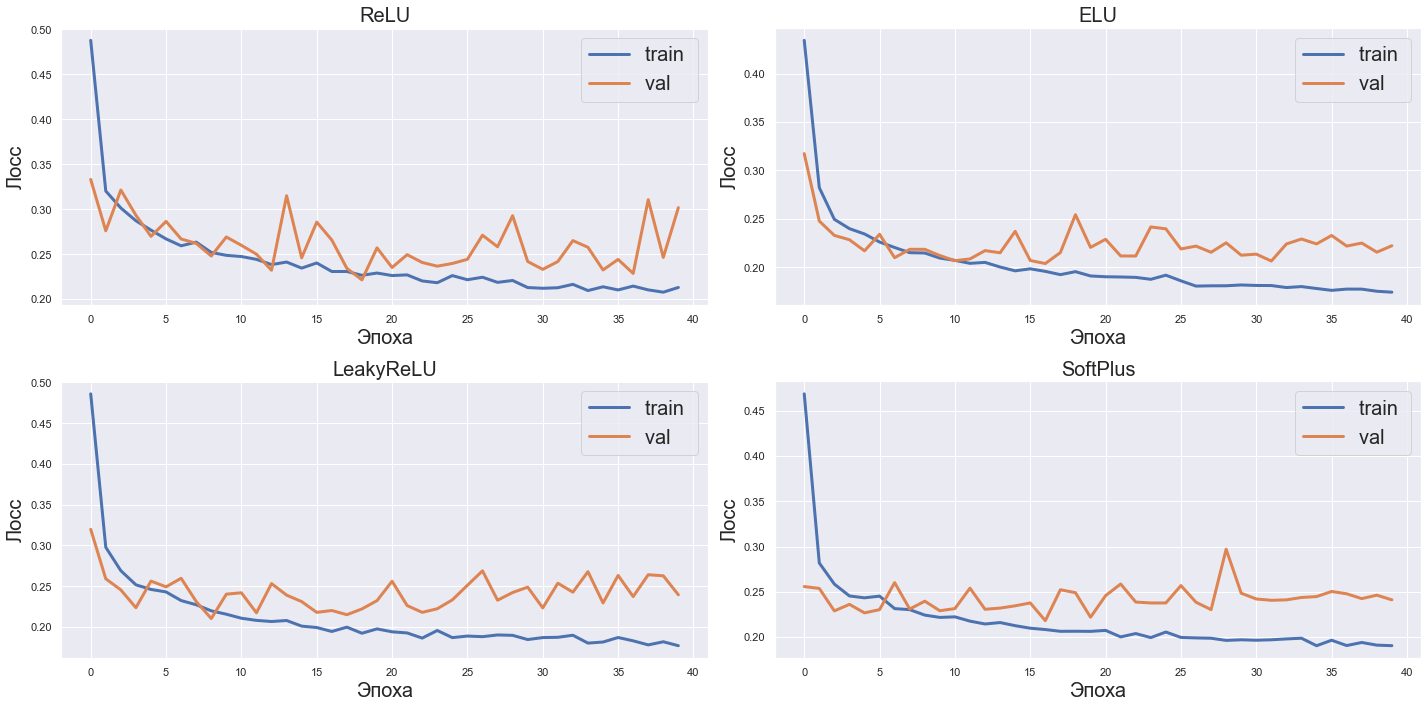

In [145]:
act_funcs = {'ReLU' : ReLU, 
             'ELU' : ELU, 
             'LeakyReLU' : LeakyReLU, 
             'SoftPlus' : SoftPlus}

train_losses = {}
val_losses = {}
train_time = {}
plt.figure(figsize=(20, 10))
for i, (name, func_module) in enumerate(act_funcs.items()):
    
    plt.subplot(2, 2, i + 1)
    
    # собираем модель по частям, больше ничего не остается
    model = Sequential()
    model.add(Flatten())
    model.add(Linear(n_features, 10))
    model.add(func_module())
    model.add(Linear(10, n_classes))
    model.add(LogSoftMax())
    
    begin_time = time()
    train_loss, val_loss = train(model, 
                                 (X_train, y_train), 
                                 (X_val, y_val), 
                                 n_epochs, 
                                 batch_size,
                                 optimizer,
                                 optimizer_params,
                                 criterion,
                                 title=name
                                 )
    end_time = time()
    train_losses[name] = train_loss
    val_losses[name] = val_loss
    train_time[name] = end_time - begin_time
    
plt.tight_layout()
plt.show()

Чтобы не перегружать общий график лосса, разобью на два: `train` и `validation`

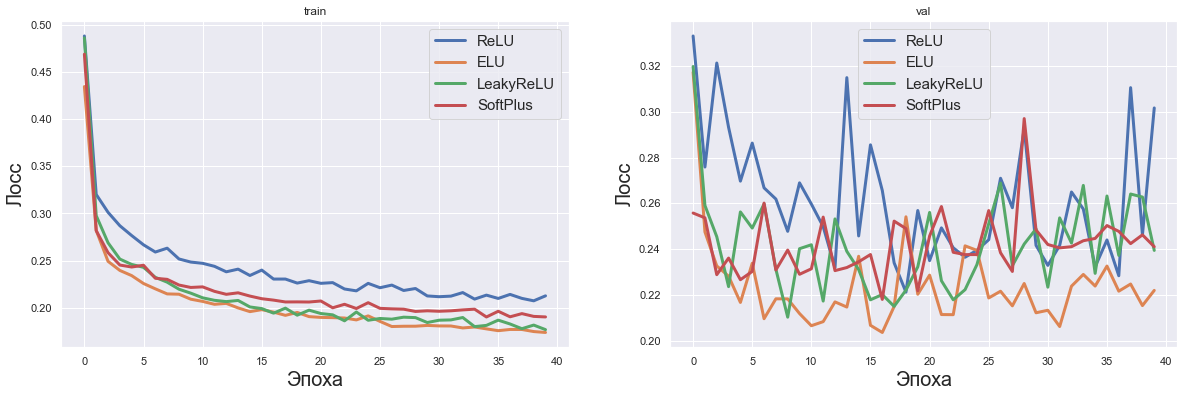

In [146]:
plt.figure(figsize=(20, 6))
for j, (losses, data_name) in enumerate(zip((train_losses, val_losses), ('train', 'val'))):
    plt.subplot(1, 2, j + 1)
    for name, loss in losses.items():
        plt.plot(loss, label=name, linewidth=3)
        
    plt.legend(fontsize=15)
    plt.xlabel('Эпоха', fontsize=20)
    plt.ylabel('Лосс', fontsize=20)
    plt.title(data_name)
plt.show()
    

Как видно, наилучшими оказались `ReLU` и `LeakyReLU`, чуть хуже `softmax`, и хуже всех `ReLU`.  
Ниже мы увидим, что по соотношению скорости обучения/качества, наилучший выбор -- `LeakyReLU`.  
Так же, плохой результат `ReLU` связан с тем, что у нас простая, совсем не глубокая архитектура, а значит особо и нет проблем (затухающего градиента), и в принципе доля нелинейности, которую вносит один слой `ReLU`, может быть недостаточной.

Write your personal opinion on the activation functions, think about computation times too.

Рассмотрим время прохождения 40 эпох при использовании различных функций активации.  
Для правильности подсчета времени усложним архитектуру сети.

In [8]:
optimizer = sgd_momentum
optimizer_params = {'config' : {'learning_rate' : 1e-1, 'momentum': 0.9},
                    'state' : {}}


criterion = ClassNLLCriterion()

n_epochs = 40
batch_size = 128

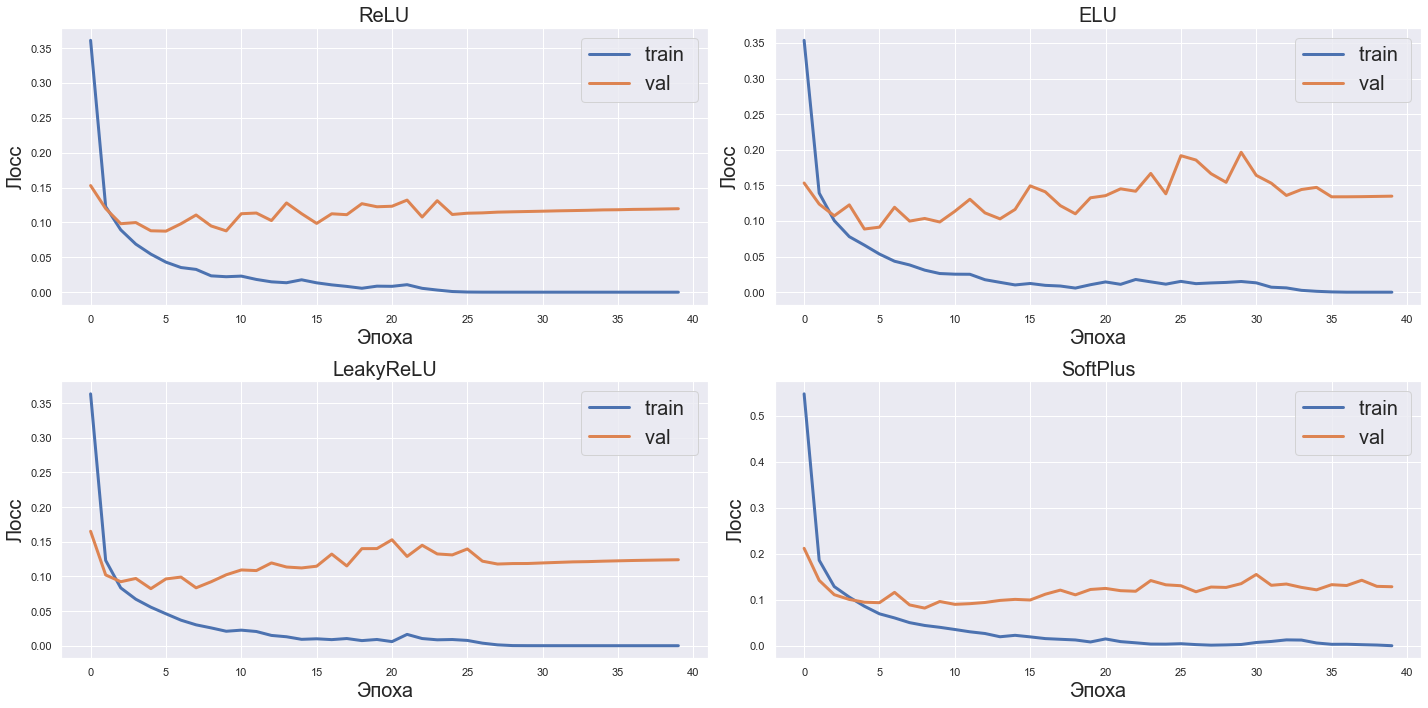

In [142]:
act_funcs = {'ReLU' : ReLU, 
             'ELU' : ELU, 
             'LeakyReLU' : LeakyReLU, 
             'SoftPlus' : SoftPlus}

train_losses = {}
val_losses = {}
train_time = {}
plt.figure(figsize=(20, 10))
for i, (name, func_module) in enumerate(act_funcs.items()):
    
    plt.subplot(2, 2, i + 1)
    
    # собираем модель по частям, больше ничего не остается
    model = Sequential()
    model.add(Flatten())
    model.add(Linear(n_features, 100))
    model.add(func_module())
    model.add(Linear(100, 200))
    model.add(func_module())
    model.add(Linear(200, n_classes))
    model.add(LogSoftMax())
    
    begin_time = time()
    train_loss, val_loss = train(model, 
                                 (X_train, y_train), 
                                 (X_val, y_val), 
                                 n_epochs, 
                                 batch_size,
                                 optimizer,
                                 optimizer_params,
                                 criterion,
                                 title=name
                                 )
    end_time = time()
    train_losses[name] = train_loss
    val_losses[name] = val_loss
    train_time[name] = end_time - begin_time
    
plt.tight_layout()
plt.show()

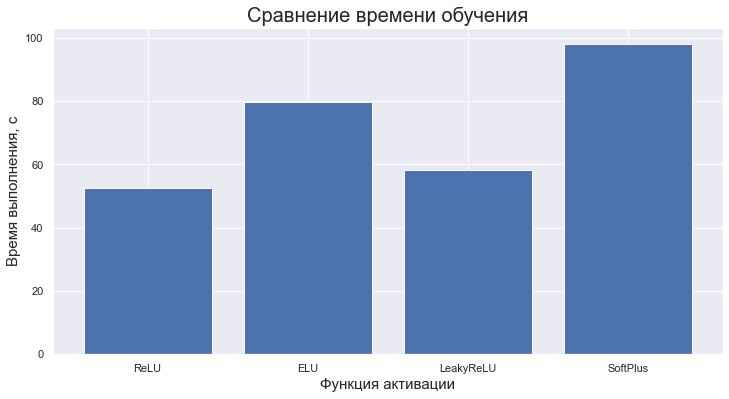

In [143]:
plt.figure(figsize=(12, 6))
plt.bar(train_time.keys(), train_time.values())
plt.title('Сравнение времени обучения', fontsize=20)
plt.xlabel('Функция активации', fontsize=15)
plt.ylabel('Время выполнения, с', fontsize=15)
plt.show()

Как видно, с различными функциями активации обучение занимает разное количество времени.  
Это происходит из-за того, что их вычисление занимает разное количество времени: 
- `ReLU` и `LeakyReLU` самые простые функции, почти линейные, вычисляются быстро.  
- `ELU` включает в себя вычисление экспоен, что сильно дольше
- `SoftPlus` вообще вычисляет экспоненту и логарифм, что еще дольше  

При этом хоть на первый по графикам видно, что со всеми функциями активациями модель переобучилась, но лучшее качество показали самые простые функции активации -- `ReLU` и `LeakyReLU`.  
Можно сделать вывод, что более сложные функции не сильно лучше простых, а то и хуже (и дольше).  

Посмотрим, что будет происходить при добавлении `BatchNorm`

In [9]:
optimizer = sgd_momentum

criterion = ClassNLLCriterion()

n_epochs = 40
batch_size = 128

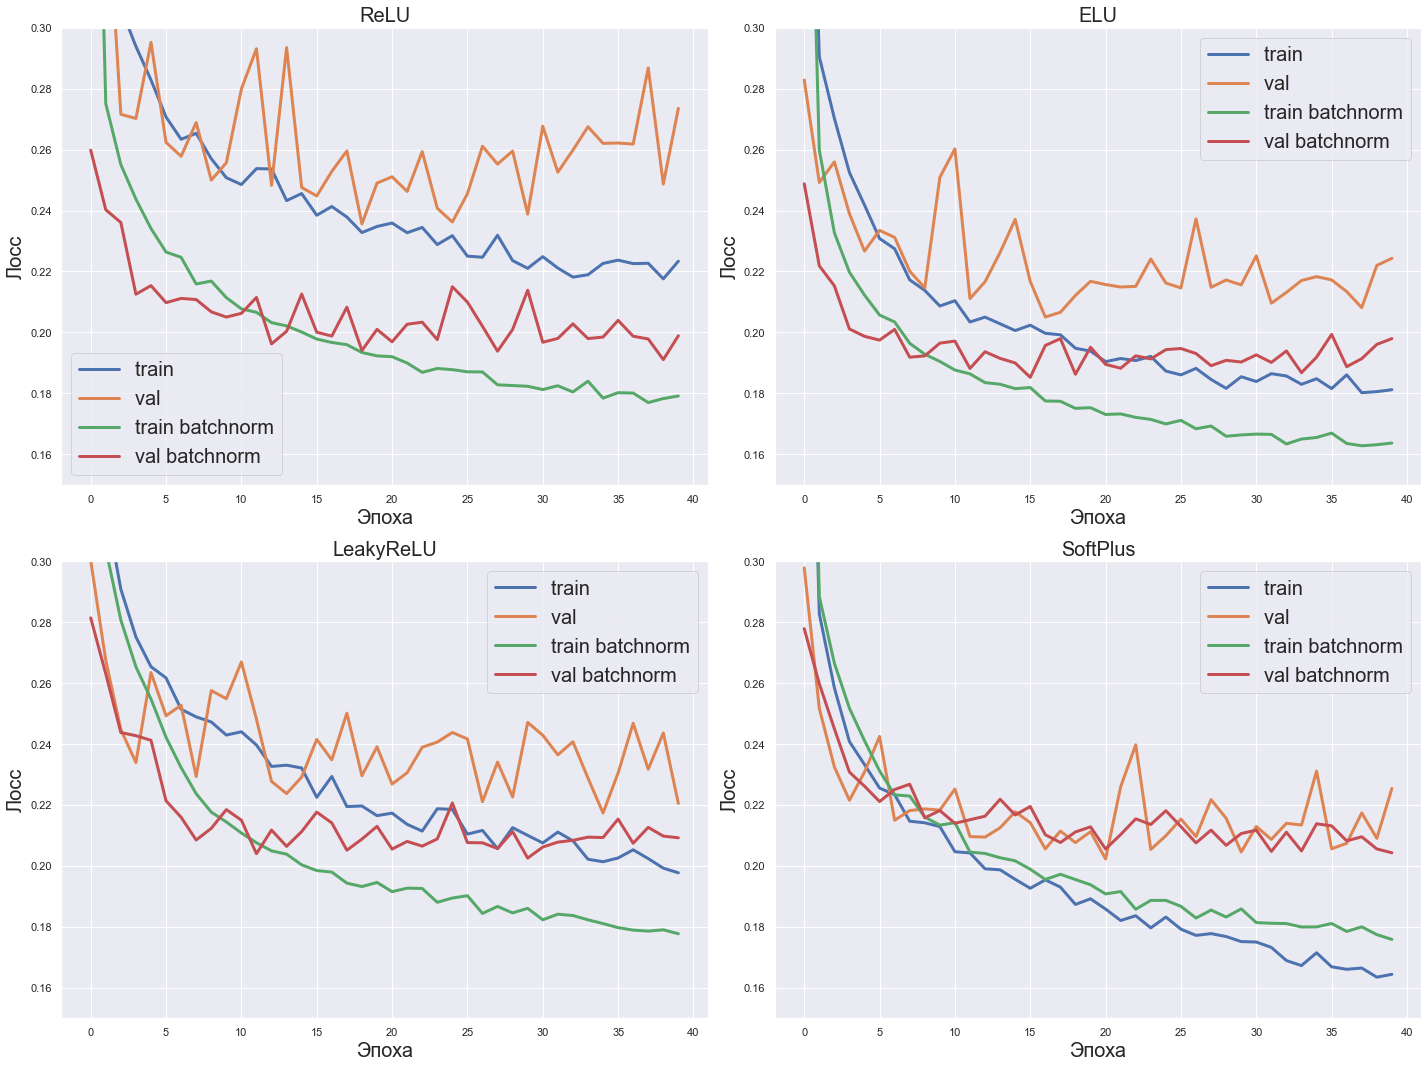

In [12]:
act_funcs = {'ReLU' : ReLU, 
             'ELU' : ELU, 
             'LeakyReLU' : LeakyReLU, 
             'SoftPlus' : SoftPlus}

train_losses_bn = {}
val_losses_bn = {}

plt.figure(figsize=(20, 15))
for i, (name, func_module) in enumerate(act_funcs.items()):
    
    plt.subplot(2, 2, i + 1)
    
    for j in range(2):
        
        optimizer_params = {'config' : {'learning_rate' : 1e-1, 'momentum': 0.9},
                            'state' : {}}
        
        model = Sequential()
        model.add(Flatten())
        model.add(Linear(n_features, 10))
        if j == 1:
            model.add(BatchNormalization(alpha=0.9))
            model.add(ChannelwiseScaling(10))
        model.add(func_module())
        model.add(Linear(10, n_classes))
        model.add(LogSoftMax())

        train_loss, val_loss = train(model, 
                                     (X_train, y_train), 
                                     (X_val, y_val), 
                                     n_epochs, 
                                     batch_size,
                                     optimizer,
                                     optimizer_params,
                                     criterion,
                                     title=name if j == 0 else None,
                                     label='' if j == 0 else 'batchnorm')
        plt.ylim((0.15, 0.3))
        
        batchnorm = '' if j == 0 else 'batchnorm'
        name = name + batchnorm
        train_losses_bn[name] = train_loss
        val_losses_bn[name] = val_loss
    
plt.tight_layout()
plt.show()

Does `BatchNormalization` help?

Как видно из графиков, результат неоднозначный.  
В случае `ReLU`, `ELU` и `LeakyReLU` `BatchNormalization` действительно ускоряет обучение, однако в случае `SoftPlus` сеть обучается примерно так же, как и без батчнорма, но плавнее.  
На одном графике рисовать все линии будет довольно некрасиво, выше визуализация вполне наглядно показывает разность в лоссе у разных функций активаций и батчнорма.

Сравним два оптимизатора на основе простой архитектуры.

In [186]:
optimizers = [sgd_momentum, adam_optimizer]
params = [{'config' : {'learning_rate' : 1e-3, 'momentum': 0.9},
           'state' : {}},
          {'config' : {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}, 
           'state' : {}}]
names = ['sgd', 'adam']
lrs = [1e-1, 1e-2]
criterion = ClassNLLCriterion()

n_epochs = 40
batch_size = 128

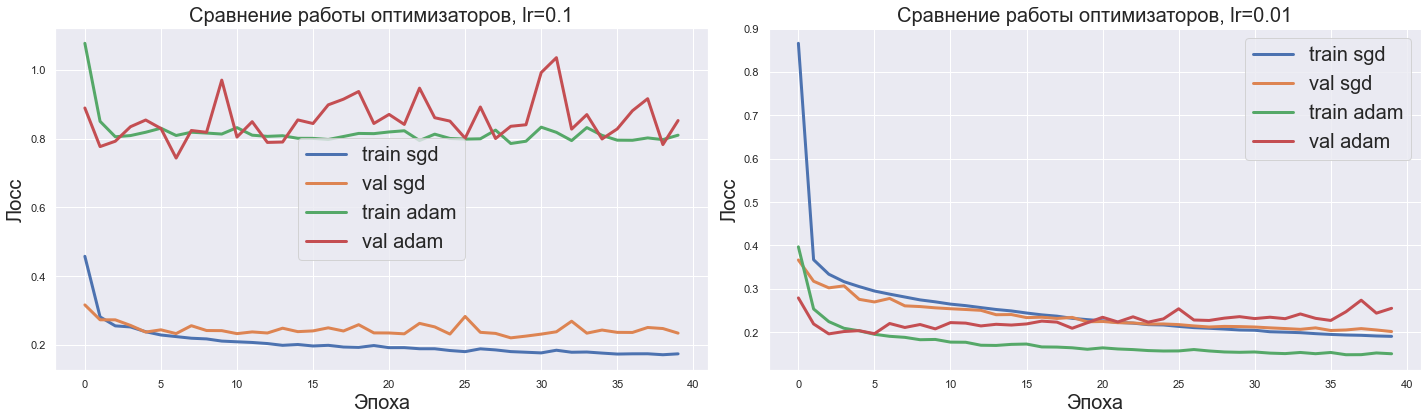

In [187]:
plt.figure(figsize=(20, 6))

for i, lr in enumerate(lrs):
    plt.subplot(1, 2, i + 1)
    for optimizer, param, name in zip(optimizers, params, names):
        param['config']['learning_rate'] = lr

        model = Sequential()
        model.add(Flatten())
        model.add(Linear(n_features, 10))
        model.add(func_module())
        model.add(Linear(10, n_classes))
        model.add(LogSoftMax())

        begin_time = time()
        train(model, 
              (X_train, y_train), 
              (X_val, y_val), 
              n_epochs, 
              batch_size,
              optimizer,
              param,
              criterion,
              title='Сравнение работы оптимизаторов, lr={}'.format(lr), 
              label=name
              )
        
plt.tight_layout()
plt.show()

Видны разные результаты.  
Качество работы оптимизатора очень сильно зависит от `lr`: если `sgd` с `lr` = 0.01 ведет себя неплохо, то `adam` показывает себя плохо. При уменьшении `lr` в 10 раз `adam` стал показывать результаты, лучше чем у `sgd`.  
Поэтому нельзя сделать однозначный вывод, какой оптимизатор лучше.  
`Adam` вполне возможно проще настраивать для сходимости в сложных архитектурах, но достаточно много раз видел утверждение, что хорошо затюненный `sgd` (с изменением `lr` в зависимости от эпохи) показывает себя лучше.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Задача действительно несложная, но ради интереса попробуем две модели с почти одинаковой архитектурой, единственное отличие -- функции активации и batchnorm.  
И посмотрим, как в зависимости от вероятности зануления в `dropout`, изменения `lr` они себя ведут.  
В качестве `lr decay` рассмотрим вариант, при котором каждые $n$ эпох он уменьшается в $k$ раз. Использовать будем оптимизатор `adam`.

In [135]:
class BasicScheduler:
    '''
    Каждые period эпох делит lr на k
    '''
    def __init__(self, config, period=5, k=2):
        self.k = k
        self.period = period
        self.config = config
        self._cur_epoch = 0
    
    def step(self):
        self._cur_epoch += 1
        if self._cur_epoch % self.period == 0:
            self.config['config']['learning_rate'] = self.config['config']['learning_rate'] / self.k

In [136]:
def custom_model(features,
                 activation, 
                 use_batchnorm=True, 
                 alpha=0.9,
                 use_dropout=True, 
                 p=0.5):
    '''
    Конструирует сеть из k блоков вида 
    [linear, batchnorm (если batchnorm=True), activation, dropout(если dropout=True)]
    p - вероятность зануления в дропауте
    features -- количества фичей в линейных слоях, 
    начиная от входной размерности, заканчивая количеством классов
    '''

    model = Sequential()
    model.add(Flatten())
    for i in range(len(features) - 2):
        model.add(Linear(features[i], features[i + 1]))
        if use_batchnorm:   
            model.add(BatchNormalization(alpha))
            model.add(ChannelwiseScaling(features[i + 1]))
        model.add(activation())
        if use_dropout:
            model.add(Dropout(p))
    model.add(Linear(features[-2], features[-1]))
    model.add(LogSoftMax())
    
    return model

In [137]:
def train_epoch_v2(model, 
                   data, 
                   batch_size, 
                   criterion, 
                   optimizer=None, 
                   optimizer_params=None):
    '''
    Одна эпоха обучения / валидации
    '''
    epoch_loss = 0
    corrects = 0
    
    for x_batch, y_batch in get_batches(data, batch_size):
        
        model.zeroGradParameters()

        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        if model.training:
            
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            optimizer(model.getParameters(), 
                      model.getGradParameters(), 
                      optimizer_params['config'],
                      optimizer_params['state'])      
            
        # заточено под нашу реализацию логлосса
        # для правильного усреднения за эпоху нужно
        # делить epoch_loss на len(data)
        epoch_loss += loss * x_batch.shape[0]
        corrects += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
        
    return epoch_loss / data[0].shape[0], corrects / data[0].shape[0]

In [138]:
def train_v2(model, 
             train_data, 
             val_data, 
             n_epochs, 
             batch_size, 
             optimizer, 
             optimizer_params,
             criterion, 
             scheduler=None):
    '''
    Наконец, когда мы в том числе заинтересовались метрикой,
    можно объявить нормальную функцию train c вычислением точности
    '''
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    for _ in range(n_epochs):
        # train
        model.train()
        loss, acc = train_epoch_v2(model, 
                                train_data, 
                                batch_size, 
                                criterion,
                                optimizer, 
                                optimizer_params)
        train_losses.append(loss)
        train_acc.append(acc)
            
        # val
        model.evaluate()
        loss, acc = train_epoch_v2(model, 
                                   val_data, 
                                   batch_size,
                                   criterion)
        val_losses.append(loss)
        val_acc.append(acc)
    
        if scheduler is not None:
            scheduler.step()

        clear_output()
        
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Лосс", fontsize=15)
        plt.plot(train_losses, label='train', linewidth=3)
        plt.plot(val_losses, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.subplot(1, 2, 2)
        plt.title('Accuracy', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Accuracy", fontsize=15)
        plt.plot(train_acc, label='train', linewidth=3)
        plt.plot(val_acc, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.show()

In [139]:
def accuracy_score(model, data, batch_size):
    '''
    Считает accuracy модели на данных
    '''
    model.evaluate()

    corrects = 0
    for x_batch, y_batch in get_batches(data, batch_size):
        predictions = model.forward(x_batch)
        corrects += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
        
    return corrects / data[0].shape[0]

Версия 1.  
Сеть c батчнормом из 1 линейного слоя.

In [146]:
features = [n_features, 10, n_classes]
model = custom_model(features, LeakyReLU, use_batchnorm=True, use_dropout=False)

In [147]:
print(model)

Flatten
Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 10 -> 10
LogSoftMax



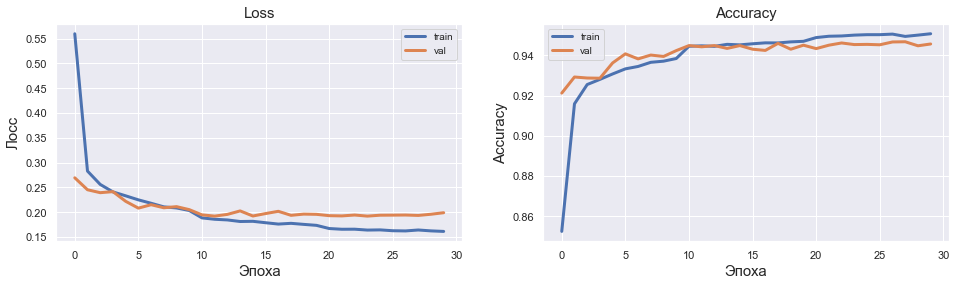

In [148]:
optimizer = adam_optimizer
params = {'config' : {'learning_rate': 1e-2, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}, 
          'state' : {}}
criterion = ClassNLLCriterion()

n_epochs = 30
batch_size = 128
scheduler = BasicScheduler(params, 10, 2)

train_v2(model, (X_train, y_train), (X_val, y_val), 
         n_epochs, batch_size, optimizer, params, 
         criterion, 
         scheduler=scheduler)

Эксперимент 2.  
Сеть с батчнормом из 3 линейных слоев.

In [149]:
features = [n_features, 10, 20, 10, n_classes]
model = custom_model(features, LeakyReLU, use_batchnorm=True, use_dropout=False)
print(model)

Flatten
Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 10 -> 20
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 20 -> 10
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 10 -> 10
LogSoftMax



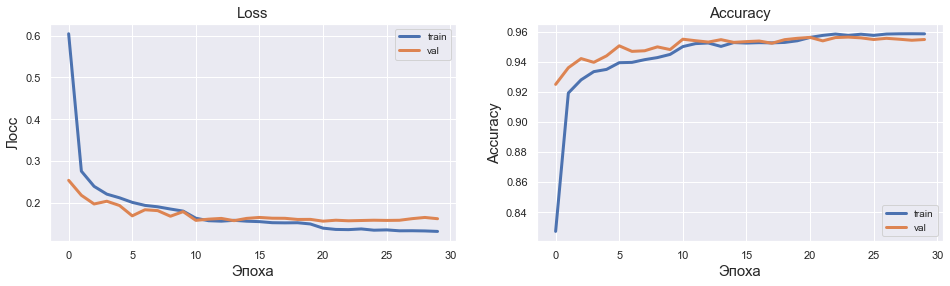

In [150]:
optimizer = adam_optimizer
params = {'config' : {'learning_rate': 1e-2, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}, 
          'state' : {}}
criterion = ClassNLLCriterion()

n_epochs = 30
batch_size = 128
scheduler = BasicScheduler(params, 10, 2)

train_v2(model, (X_train, y_train), (X_val, y_val), 
         n_epochs, batch_size, optimizer, params, 
         criterion, 
         scheduler=scheduler)

Print here your accuracy on test set. It should be around 90%.

In [151]:
accuracy_score(model, (X_test, y_test), 256)

0.9523

Попробовал две модели с разным количеством слоев, последняя оказалась лучше.  
Нужной точности мы добились, с игрушечной задачей справились.  
Дропаут здесь не так нужен, модель не слишком сильно переобучается, а батчнорм ускоряет обучение.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [220]:
def train_epoch_v3(model, 
                   data, 
                   batch_size, 
                   criterion, 
                   optimizer=None, 
                   optimizer_params=None, 
                   is_train=True):
    '''
    Одна эпоха обучения / валидации
    '''
    epoch_loss = 0.0
    corrects = 0.0
    
    model.train(is_train)
    
    for x_batch, y_batch in get_batches(data, batch_size):
        
        x_batch = torch.FloatTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch.argmax(axis=1))
        
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # заточено под нашу реализацию логлосса
        # для правильного усреднения за эпоху нужно
        # делить epoch_loss на len(data)
        epoch_loss += loss * x_batch.size(0)
        corrects += (predictions.argmax(dim=1) == y_batch.argmax(dim=1)).sum()
        
    return epoch_loss / data[0].shape[0], corrects / data[0].shape[0]

In [226]:
def train_v3(model, 
             train_data, 
             val_data, 
             n_epochs, 
             batch_size, 
             optimizer,
             criterion, 
             scheduler=None):
    '''
    Наконец, когда мы в том числе заинтересовались метрикой,
    можно объявить нормальную функцию train c вычислением точности
    '''
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    for _ in range(n_epochs):
        # train
        loss, acc = train_epoch_v3(model, 
                                train_data, 
                                batch_size, 
                                criterion,
                                optimizer)
        train_losses.append(loss)
        train_acc.append(acc)
            
        # val
        loss, acc = train_epoch_v3(model, 
                                   val_data, 
                                   batch_size,
                                   criterion, 
                                   is_train=False)
        

        val_losses.append(loss)
        val_acc.append(acc)
    
        if scheduler is not None:
            scheduler.step()

        clear_output()
        
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Лосс", fontsize=15)
        plt.plot(train_losses, label='train', linewidth=3)
        plt.plot(val_losses, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.subplot(1, 2, 2)
        plt.title('Accuracy', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Accuracy", fontsize=15)
        plt.plot(train_acc, label='train', linewidth=3)
        plt.plot(val_acc, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.show()

In [227]:
class MyModelTorch(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Linear(10, 20),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(),
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LogSoftmax()                      
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [228]:
model = MyModelTorch()
model

MyModelTorch(
  (model): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=10, bias=True)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): LogSoftmax()
  )
)

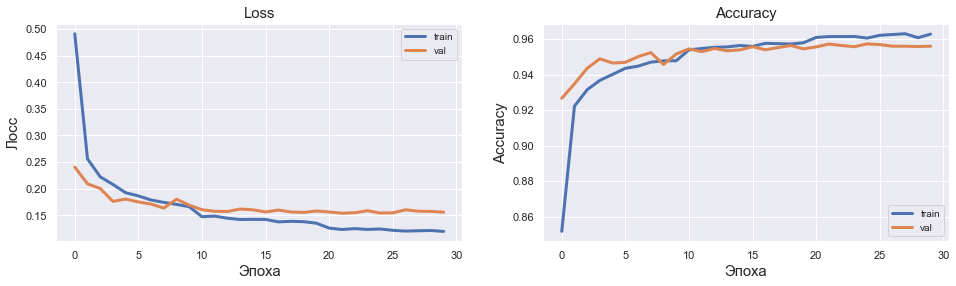

In [229]:
n_epochs = 30
batch_size = 128

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

train_v3(model, (X_train, y_train), (X_val, y_val), 
         n_epochs, batch_size, optimizer,
         criterion, 
         scheduler=scheduler)

***Вывод***  
Мы правильно реализовали свой собственный мини-фреймворк для обучения сетей.  
И он показал аналогичный результат с реализацией из `Pytorch`.

P.S. извиняюсь за 3 почти одинаковые функции `train`, просто от вопроса к вопросу все-таки требовалось различный формат обучения, и требования были разные.